<a href="https://colab.research.google.com/github/iamfaham/llama-3.2-GRPO-finetuned/blob/main/Llama_3_2_GRPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 🌱 Setup: Installs & Imports (Colab)
# - Installs Unsloth, TRL (GRPO), Datasets, and optional vLLM.
# - Safe to re-run.

%%capture
!pip -q install --upgrade pip
!pip -q install --no-deps unsloth unsloth-zoo transformers trl accelerate peft datasets einops bitsandbytes evaluate fugashi ipywidgets

# vLLM (optional). If this fails on Colab, we fallback gracefully.
try:
    !pip -q install vllm==0.8.5.post1
    VLLM_OK = True
except Exception:
    VLLM_OK = False

import os, math, random, re, json, gc, time
from typing import List, Dict, Any
import numpy as np
import torch
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets
import evaluate
import matplotlib.pyplot as plt
from dataclasses import dataclass
from transformers import AutoTokenizer
from unsloth import FastLanguageModel
from peft import LoraConfig
from trl import SFTTrainer, SFTConfig, GRPOTrainer, GRPOConfig
import requests

f = requests.get("https://raw.githubusercontent.com/vllm-project/vllm/refs/heads/main/requirements/common.txt").content
with open("vllm_requirements.txt", "wb") as file:
  file.write(re.sub(rb"(transformers|numpy|xformers)[^\n]{1,}\n", b"", f))
!pip install -r vllm_requirements.txt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)
print('CUDA capability:', torch.cuda.get_device_name(0) if device=='cuda' else 'CPU')
print('vLLM available:', VLLM_OK)


In [2]:
# Configuration: Choose Model & Training Settings

USE_QWEN = False  # True → Qwen3-4B-Base; False → select LLaMA variant below
LLAMA_VARIANT = "unsloth/Llama-3.2-3B"  # "unsloth/Llama-3.2-3B" or "unsloth/Llama-3.2-8B"

GRADIENT_CHECKPOINTING = True
MIXED_PRECISION = "fp16"   # "bf16", "fp16", or "fp32"
MAX_SEQ_LEN = 2048
TARGET_GPU_UTIL = 0.7
USE_VLLM = False # Set to False as fast_inference is disabled during model loading

# SFT
SFT_EPOCHS = 2
SFT_SUBSET_SIZE = 600
BATCH_SIZE = 1
GRAD_ACCUM_STEPS = 2
LR_SFT = 2e-4

# GRPO
LR_GRPO = 1e-5
GRPO_STEPS = 300

# Eval
EVAL_SAMPLES = 200
SEED = 42

dtype_map = {
    "bf16": torch.bfloat16,
    "fp16": torch.float16,
    "fp32": None  # unsloth will pick default
}

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
BASE_MODEL = "unsloth/Qwen3-4B-Base" if USE_QWEN else LLAMA_VARIANT
print('Base model:', BASE_MODEL)

def gpu_memory_gb():
    if device != 'cuda':
        return 0.0, 0.0
    torch.cuda.synchronize()
    allocated = torch.cuda.memory_allocated() / (1024**3)
    reserved = torch.cuda.memory_reserved() / (1024**3)
    return allocated, reserved

print('GPU mem (GB):', gpu_memory_gb())

Base model: unsloth/Llama-3.2-3B
GPU mem (GB): (0.0, 0.0)


In [3]:
# 📥 Load & Normalize Datasets to Chat Format
# Format:
# System: "You are a financial and math reasoning assistant. Use step-by-step reasoning."
# User: "<problem>"
# Assistant: "<start_contemplating> ... <end_contemplating><SOLUTION>final</SOLUTION>"

SYSTEM_PROMPT = "You are a financial and math reasoning assistant. Use step-by-step reasoning."

def extract_final_number(text: str):
    m = re.search(r"####\s*([-+]?[0-9]*\.?[0-9]+)", text)
    if m:
        try: return float(m.group(1))
        except: pass
    nums = re.findall(r"[-+]?[0-9]*\.?[0-9]+", text)
    if nums:
        try: return float(nums[-1])
        except: return None
    return None

def make_chat_example(question: str, rationale: str=None, answer: str=None):
    reasoning = rationale.strip() if rationale else ("Let's solve it step by step.")
    final = answer.strip() if answer else ("Unknown")
    assistant = f"<start_contemplating> {reasoning} <end_contemplating><SOLUTION>{final}</SOLUTION>"
    return {
        "messages": [
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": question.strip()},
            {"role": "assistant", "content": assistant}
        ],
        "question": question.strip(),
        "final": final,
    }

def load_gsm8k_split(split="train"):
    ds = load_dataset("gsm8k", "main", split=split)
    rows = []
    for ex in ds:
        q = ex.get('question','')
        a = ex.get('answer','')
        final_num = extract_final_number(a)
        final_str = str(final_num) if final_num is not None else a.strip()
        rows.append(make_chat_example(q, a, final_str))
    return Dataset.from_list(rows)

def load_aqua_rat_split(split="train"):
    ds = load_dataset("aqua_rat", split=split)
    rows = []
    for ex in ds:
        q = ex.get('question','')
        options = ex.get('options', [])
        rationale = ex.get('rationale','')
        correct = ex.get('correct','')  # letter
        final = correct
        try:
            letters = ['A','B','C','D','E','F','G']
            if correct in letters and len(options) >= letters.index(correct)+1:
                final = options[letters.index(correct)]
        except: pass
        q_text = q
        if options:
            q_text += "\nOptions: " + "; ".join([f"({chr(65+i)}) {opt}" for i,opt in enumerate(options)])
        rows.append(make_chat_example(q_text, rationale, str(final)))
    return Dataset.from_list(rows)

def load_finqa_split(split="train"):
    candidates = [
        {"path": "finqa"},
        {"path": "ydshieh/finqa"},
        {"path": "bigbio/finqa", "name": "finqa"},
    ]
    ds = None
    for cand in candidates:
        try:
            ds = load_dataset(cand["path"], cand.get("name"), split=split)
            break
        except Exception:
            ds = None
            continue
    rows = []
    if ds is None:
        print("FinQA not found; returning empty dataset.")
        return Dataset.from_list(rows)
    for ex in ds:
        question = ex.get('question') or ex.get('q', '')
        rationale = ex.get('program', '') or ex.get('rationale','')
        answer = str(ex.get('answer',''))
        rows.append(make_chat_example(question, rationale, answer))
    return Dataset.from_list(rows)

def load_tatqa_split(split="train"):
    candidates = [
        {"path": "TAT-QA"},
        {"path": "lucadili/TAT-QA"},
        {"path": "yalechen1999/TAT-QA"},
    ]
    ds = None
    for cand in candidates:
        try:
            ds = load_dataset(cand["path"], split=split)
            break
        except Exception:
            continue
    rows = []
    if ds is None:
        print("TAT-QA not found; returning empty dataset.")
        return Dataset.from_list(rows)
    for ex in ds:
        question = ex.get('question','')
        rationale = ex.get('evidence','') or ex.get('derivation','') or ''
        answer = str(ex.get('answer',''))
        rows.append(make_chat_example(question, rationale, answer))
    return Dataset.from_list(rows)

def load_all_datasets():
    gsm_train = load_gsm8k_split("train")
    aqua_train = load_aqua_rat_split("train")
    finqa_train = load_finqa_split("train")
    tatqa_train = load_tatqa_split("train")
    train = concatenate_datasets([gsm_train, aqua_train, finqa_train, tatqa_train])

    gsm_test = load_gsm8k_split("test")
    aqua_test = load_aqua_rat_split("test")
    try: finqa_test = load_finqa_split("test")
    except: finqa_test = Dataset.from_list([])
    try: tatqa_test = load_tatqa_split("test")
    except: tatqa_test = Dataset.from_list([])
    test = concatenate_datasets([gsm_test, aqua_test, finqa_test, tatqa_test])
    return train, test

train_raw, test_raw = load_all_datasets()
print('Train size (raw):', len(train_raw), ' Test size (raw):', len(test_raw))

# Tokenizer, chat-template text, and 90th pct length filter
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

def to_chat_text(messages: List[Dict[str,str]]):
    try:
        return tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)
    except Exception:
        sys_msg = next((m['content'] for m in messages if m['role']=='system'), SYSTEM_PROMPT)
        user = next((m['content'] for m in messages if m['role']=='user'), '')
        assistant = next((m['content'] for m in messages if m['role']=='assistant'), '')
        return f"<|system|>\n{sys_msg}\n<|user|>\n{user}\n<|assistant|>\n{assistant}"

def add_text(example):
    example['text'] = to_chat_text(example['messages'])
    return example

train_txt = train_raw.map(add_text)
test_txt  = test_raw.map(add_text)

lengths = [len(tokenizer(ex['text']).input_ids) for ex in train_txt]
p90 = int(np.percentile(lengths, 90))
CUT_LEN = min(MAX_SEQ_LEN, max(256, p90))
print('Token length P90:', p90, ' → CUT_LEN:', CUT_LEN)

def filter_by_len(example):
    return len(tokenizer(example['text']).input_ids) <= CUT_LEN

train_filt = train_txt.filter(filter_by_len)
test_filt  = test_txt.filter(filter_by_len)
print('Train size (filtered):', len(train_filt), ' Test size (filtered):', len(test_filt))

# Subset for SFT format enforcement
sft_subset = train_filt.shuffle(seed=SEED).select(range(min(SFT_SUBSET_SIZE, len(train_filt))))
print('SFT subset size:', len(sft_subset))


README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

raw/train-00000-of-00001.parquet:   0%|          | 0.00/25.4M [00:00<?, ?B/s]

raw/test-00000-of-00001.parquet:   0%|          | 0.00/74.0k [00:00<?, ?B/s]

raw/validation-00000-of-00001.parquet:   0%|          | 0.00/76.1k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/97467 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/254 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/254 [00:00<?, ? examples/s]

FinQA not found; returning empty dataset.
TAT-QA not found; returning empty dataset.
FinQA not found; returning empty dataset.
TAT-QA not found; returning empty dataset.
Train size (raw): 104940  Test size (raw): 1573


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

Map:   0%|          | 0/104940 [00:00<?, ? examples/s]

Map:   0%|          | 0/1573 [00:00<?, ? examples/s]

Token length P90: 292  → CUT_LEN: 292


Filter:   0%|          | 0/104940 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1573 [00:00<?, ? examples/s]

Train size (filtered): 94508  Test size (filtered): 1425
SFT subset size: 600


In [4]:
# 🧠 Load Base Model with Unsloth + LoRA (no quantization now; future work can add QLoRA)

from unsloth import FastLanguageModel
from peft import LoraConfig

# Colab Pro has enough VRAM for Qwen3-4B or LLaMA 3.2-8B (if careful with batch size).
# Keep load_in_4bit=False here per constraints, but you can change later.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = BASE_MODEL,
    max_seq_length = CUT_LEN,
    dtype = dtype_map[MIXED_PRECISION],  # "bf16" on T4/P100 works well
    load_in_4bit = False,
    fast_inference = True # vLLM fast inference Enabled
)

# Ensure pad_token exists
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj"
    ], use_gradient_checkpointing = "unsloth",
)

# Enable gradient checkpointing for memory savings

# Small sanity check: tokenize + decode a message
test_text = "Test message for tokenizer."
print("Tokenized IDs:", tokenizer(test_text).input_ids)
print("Decoded:", tokenizer.decode(tokenizer(test_text).input_ids))

print(model)
alloc, reserved = gpu_memory_gb()
print(f"GPU mem after load (GB): allocated={alloc:.2f}, reserved={reserved:.2f}")

Unsloth: Patching vLLM v1 graph capture
Unsloth: Patching vLLM v0 graph capture
==((====))==  Unsloth 2025.8.6: Fast Llama patching. Transformers: 4.55.1. vLLM: 0.8.5.post1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/Llama-3.2-3B with actual GPU utilization = 49.53%
Unsloth: Your GPU has CUDA compute capability 7.5 with VRAM = 14.74 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 292. Num Sequences = 128.
Unsloth: vLLM's KV Cache can use up to 1.14 GB. Also swap space = 0 GB.


generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


Capturing CUDA graph shapes:   0%|          | 0/19 [00:00<?, ?it/s]

Unsloth: Just some info: will skip parsing ['q_norm', 'pre_feedforward_layernorm', 'post_feedforward_layernorm', 'k_norm']
Unsloth: Just some info: will skip parsing ['q_norm', 'pre_feedforward_layernorm', 'post_feedforward_layernorm', 'k_norm']


tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

Tokenized IDs: [128000, 2323, 1984, 369, 47058, 13]
Decoded: <|begin_of_text|>Test message for tokenizer.
PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 3072, padding_idx=128004)
        (layers): ModuleList(
          (0-27): 28 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=3072, out_features=3072, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3072, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=3072, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding

In [5]:
# 🔧 SFT (format enforcement)

sft_args = SFTConfig(
    output_dir = "./sft_out",
    num_train_epochs = SFT_EPOCHS,
    per_device_train_batch_size = BATCH_SIZE,
    gradient_accumulation_steps = GRAD_ACCUM_STEPS,
    learning_rate = LR_SFT,
    lr_scheduler_type = "cosine",
    warmup_steps = 5,
    warmup_ratio = 0.05,
    logging_steps = 10,
    save_strategy = "epoch",
    report_to = "none"
)

def formatting_func(examples):
    return [ex['text'] for ex in examples]

sft_trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    args=sft_args,
    train_dataset=sft_subset,
    dataset_text_field=None,
    formatting_func=formatting_func,
)

sft_trainer.train()
sft_trainer.save_model("./sft_out")
tokenizer.save_pretrained("./sft_out")
print('SFT complete.')


Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/600 [00:00<?, ? examples/s]

Step,Training Loss
10,1.694700
20,0.882700
30,0.764700
40,0.847800
50,0.862900
60,0.766800
70,0.897500
80,0.804500
90,0.841600
100,0.887000


SFT complete.


In [6]:
# ===== GRPO block =====

import re
import numpy as np
import torch
from trl import GRPOConfig, GRPOTrainer

# -------------------
# Helpers (robust across shapes)
# -------------------
def _completion_to_text(comp):
    """
    Accepts many possible shapes for 'completion' that trainers may pass:
    - a string
    - a list like [[{"content": "..."}, ...], ...] (common in Unsloth notebooks)
    - a list of dicts: [{"content": "..."}]
    - a nested structure; we attempt to return the sensible string.
    """
    if comp is None:
        return ""
    # If it's a list, try to find first string-like entry
    if isinstance(comp, (list, tuple)):
        # If list of dicts
        first = comp[0] if len(comp) > 0 else ""
        if isinstance(first, dict):
            # typical: first = {"content": "..."}
            return first.get("content", "") if "content" in first else str(first)
        # if first item is string
        if isinstance(first, str):
            return first
        # else recursively try to stringify
        return str(first)
    # If it's dict-like
    if isinstance(comp, dict):
        return comp.get("content", "") if "content" in comp else str(comp)
    # fallback to str
    return str(comp)

def parse_solution_from_text(text: str):
    """Return the text enclosed in <SOLUTION>...</SOLUTION> if present, else None."""
    if not text:
        return None
    m = re.search(r"<SOLUTION>(.*?)</SOLUTION>", text, flags=re.S)
    if m:
        return m.group(1).strip()
    # fallback: sometimes answer is at end after '####' (GSM8K)
    m2 = re.search(r"####\s*([-+]?[0-9]*\.?[0-9]+)", text)
    if m2:
        return m2.group(1).strip()
    # fallback: last numeric token
    nums = re.findall(r"[-+]?[0-9]*\.?[0-9]+", text)
    if nums:
        return nums[-1]
    return None

def extract_final_number_safe(text: str):
    """Try to parse a number from text, return float or None."""
    if text is None:
        return None
    try:
        # strip commas
        s = str(text).strip().replace(",", "")
        return float(s)
    except:
        # try extracting via regex
        m = re.search(r"[-+]?[0-9]*\.?[0-9]+", str(text))
        if m:
            try:
                return float(m.group(0))
            except:
                return None
    return None

# -------------------
# Reward functions with correct signatures
# Each must accept: prompts, completions, completion_ids (and optionally 'answer' if trainer passes it)
# Return: numpy array / list of floats (one per completion)
# -------------------

def reward_match_format_exactly(prompts=None, completions=None, completion_ids=None, answer=None, **kwargs):
    """
    +3 if both <start_contemplating>...<end_contemplating> AND <SOLUTION>...</SOLUTION> present in correct order.
    """
    outs = []
    for comp in completions:
        text = _completion_to_text(comp)
        has_work = bool(re.search(r"<start_contemplating>.*?<end_contemplating>", text, flags=re.S))
        has_sol  = bool(re.search(r"<SOLUTION>.*?</SOLUTION>", text, flags=re.S))
        outs.append(3.0 if (has_work and has_sol) else 0.0)
    return np.array(outs, dtype=np.float32)

def reward_match_format_approx(prompts=None, completions=None, completion_ids=None, answer=None, **kwargs):
    """
    Partial reward for presence of tags (0.5 each for work/solution, capped at 1.0).
    """
    outs = []
    for comp in completions:
        text = _completion_to_text(comp)
        score = 0.0
        if "<start_contemplating>" in text or "<end_contemplating>" in text:
            score += 0.5
        if "<SOLUTION>" in text or "</SOLUTION>" in text:
            score += 0.5
        outs.append(min(score, 1.0))
    return np.array(outs, dtype=np.float32)

def reward_check_answer(prompts=None, completions=None, completion_ids=None, answer=None, **kwargs):
    """
    Reward numeric correctness using `answer` if trainer passes it (common in Unsloth setups).
    - +5 exact numeric match
    - +2 if within ±10%
    - fallback: +5 if string match
    If `answer` is not provided, attempt to infer it from `prompts` or return 0.
    """
    outs = []
    # normalize provided references if exist
    refs = None
    if answer is not None:
        refs = list(answer)
    else:
        # try to see if kwargs contains common names ('reference','references','labels','label')
        for k in ("reference","references","answer","labels","label"):
            if k in kwargs and kwargs[k] is not None:
                refs = list(kwargs[k])
                break

    # If refs is still None, try to pull numeric from prompt (best-effort) -> not ideal, but avoid crashing
    if refs is None:
        inferred = []
        for p in prompts:
            p_text = _completion_to_text(p) if not isinstance(p, str) else p
            # sometimes we embed reference in prompt in the dataset; attempt last token numeric
            inferred_val = None
            m = re.search(r"Answer[:\s]*([-+]?[0-9]*\.?[0-9]+)", p_text)
            if m:
                inferred_val = m.group(1)
            inferred.append(inferred_val)
        refs = inferred

    for comp, ref in zip(completions, refs):
        text = _completion_to_text(comp)
        pred = parse_solution_from_text(text) or text
        # if no ref, give 0 (can't judge)
        if ref is None:
            outs.append(0.0)
            continue
        # numeric compare
        pred_num = extract_final_number_safe(pred)
        ref_num  = extract_final_number_safe(ref)
        if pred_num is not None and ref_num is not None:
            if abs(pred_num - ref_num) < 1e-9:
                outs.append(5.0)
            elif abs(pred_num - ref_num) / max(1e-9, abs(ref_num)) <= 0.10:
                outs.append(2.0)
            else:
                outs.append(0.0)
        else:
            # string fallback
            outs.append(5.0 if str(pred).strip() == str(ref).strip() else 0.0)
    return np.array(outs, dtype=np.float32)

def reward_bonus_step_presence(prompts=None, completions=None, completion_ids=None, answer=None, **kwargs):
    """
    +1 if reasoning span non-empty.
    """
    outs = []
    for comp in completions:
        text = _completion_to_text(comp)
        m = re.search(r"<start_contemplating>(.*?)<end_contemplating>", text, flags=re.S)
        if not m:
            outs.append(0.0)
            continue
        content = m.group(1).strip()
        outs.append(1.0 if len(content) > 0 else 0.0)
    return np.array(outs, dtype=np.float32)

# -------------------
# Prepare RL dataset for GRPO (reuse earlier `train_filt` if present)
# -------------------
# If you already created train_for_rl earlier, this will override it safely.
train_for_rl = train_filt.shuffle(seed=SEED).select(range(min(2000, len(train_filt))))
print("GRPO: RL train size:", len(train_for_rl))

class RLRewardDataset(torch.utils.data.Dataset):
    def __init__(self, ds):
        self.ds = ds
    def __len__(self):
        return len(self.ds)
    def __getitem__(self, idx):
        ex = self.ds[int(idx)]
        # We provide both 'prompt' and 'answer' fields - TRL/Unsloth will pass 'prompts' and 'answer' to reward funcs
        return {
            "prompt": to_chat_text([
                {"role":"system","content":SYSTEM_PROMPT},
                {"role":"user","content":ex['question']},
            ]),
            "answer": ex['final'],
        }

rl_ds = RLRewardDataset(train_for_rl)

# -------------------
# GRPOConfig & Trainer init (robust)
# -------------------
# compute sensible max lengths (fallback to CUT_LEN)
from vllm import SamplingParams

max_prompt_length = min(1024, CUT_LEN // 2)
max_completion_length = min(1024, CUT_LEN - max_prompt_length)

vllm_sampling_params = SamplingParams(
    min_p = 0.1,
    top_p = 1.0,
    top_k = -1,
    seed = 3407,
    stop = [tokenizer.eos_token],
    include_stop_str_in_output = True,
)

grpo_cfg = GRPOConfig(
    vllm_sampling_params = vllm_sampling_params,
    output_dir = "./grpo_out",
    learning_rate = LR_GRPO,
    per_device_train_batch_size = BATCH_SIZE,
    gradient_accumulation_steps = GRAD_ACCUM_STEPS,
    logging_steps = 10,
    lr_scheduler_type = "cosine",
    warmup_ratio = 0.04,
    report_to = "none",
    optim = "adamw_8bit",
    save_steps = 10000,
    # bf16 = (MIXED_PRECISION == "bf16" or MIXED_PRECISION is torch.bfloat16),
    fp16 = (MIXED_PRECISION == "fp16" or MIXED_PRECISION is torch.float16),
    max_steps = GRPO_STEPS,
    max_prompt_length = max_prompt_length,
    max_completion_length = max_completion_length,
)

use_vllm_final = (USE_VLLM and ('VLLM_OK' in globals() and VLLM_OK))
print("Using vLLM in GRPO:", use_vllm_final)

# Create trainer
try:
    grpo_trainer = GRPOTrainer(
        model=model,
        args=grpo_cfg,
        tokenizer=tokenizer,
        train_dataset=rl_ds,
        reward_funcs=[
            reward_match_format_exactly,
            reward_match_format_approx,
            reward_check_answer,
            reward_bonus_step_presence,
        ],
        use_vllm=use_vllm_final,
        max_new_tokens=256,
        temperature=0.7,
        top_p=0.95,
    )
except TypeError:
    # Older TRL/Unsloth versions may not accept `use_vllm`; fall back
    grpo_trainer = GRPOTrainer(
        model=model,
        args=grpo_cfg,
        tokenizer=tokenizer,
        train_dataset=rl_ds,
        reward_funcs=[
            reward_match_format_exactly,
            reward_match_format_approx,
            reward_check_answer,
            reward_bonus_step_presence,
        ],
        max_new_tokens=256,
        temperature=0.7,
        top_p=0.95,
    )

# -------------------
# Train GRPO
# -------------------
print("Starting GRPO training (steps = {})...".format(GRPO_STEPS))
grpo_logs = grpo_trainer.train()
print("GRPO training finished; saving.")
grpo_trainer.save_model("./grpo_out")
tokenizer.save_pretrained("./grpo_out")
print("Saved GRPO outputs to ./grpo_out")


GRPO: RL train size: 2000
Unsloth: We now expect `per_device_train_batch_size` to be a multiple of `num_generations`.
We will change the batch size of 1 to the `num_generations` of 8
Using vLLM in GRPO: False
Starting GRPO training (steps = 300)...
Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,kl,entropy,rewards / reward_match_format_exactly / mean,rewards / reward_match_format_exactly / std,rewards / reward_match_format_approx / mean,rewards / reward_match_format_approx / std,rewards / reward_check_answer / mean,rewards / reward_check_answer / std,rewards / reward_bonus_step_presence / mean,rewards / reward_bonus_step_presence / std
10,0.008100,6.312500,2.512166,95.743750,47.000000,144.000000,0.200000,83.902274,47.000000,123.000000,8.059699,0,2.531250,0.824502,0.931250,0.134160,1.975000,1.897433,0.875000,0.254754
20,0.002900,5.959375,2.448809,100.475000,51.700000,145.200000,0.256250,85.793474,51.700000,129.100000,2.871850,No Log,2.362500,0.962945,0.909375,0.151866,1.850000,1.986612,0.837500,0.295768
30,0.004000,6.500000,2.496203,96.618750,48.000000,145.300000,0.187500,85.472849,48.000000,130.600000,3.960030,No Log,2.681250,0.805962,0.956250,0.115674,1.943750,2.097767,0.918750,0.226937
40,0.008300,6.328125,2.080622,90.518750,50.400000,145.400000,0.118750,84.157773,50.400000,131.100000,8.340067,No Log,2.737500,0.631174,0.965625,0.087500,1.700000,1.942232,0.925000,0.200000
50,0.101300,5.906250,2.427772,97.406250,52.400000,146.000000,0.193750,87.593019,52.400000,131.400000,101.293710,No Log,2.606250,0.883262,0.931250,0.144830,1.493750,2.069706,0.875000,0.269421
60,0.005300,6.756250,2.701101,95.575000,50.600000,143.800000,0.162500,86.149820,50.600000,131.300000,5.267632,No Log,2.700000,0.721956,0.956250,0.106251,2.175000,2.323545,0.925000,0.194189
70,0.004300,5.915625,2.957368,97.325000,47.000000,143.800000,0.225000,82.688696,47.000000,126.100000,4.291351,No Log,2.418750,1.083673,0.921875,0.168996,1.737500,2.272728,0.837500,0.340120
80,0.013800,5.953125,2.552655,91.131250,48.300000,143.700000,0.137500,82.977182,48.300000,133.100000,13.832449,No Log,2.643750,0.748862,0.946875,0.121660,1.462500,2.103954,0.900000,0.238911
90,0.003700,6.328125,2.484948,88.781250,44.600000,145.500000,0.162500,78.771317,44.600000,129.900000,3.723380,No Log,2.643750,0.648042,0.946875,0.108007,1.843750,2.021060,0.893750,0.216014
100,0.007800,5.431250,2.580148,101.562500,50.500000,146.000000,0.243750,87.120267,50.500000,133.800000,7.788215,No Log,2.418750,1.049120,0.906250,0.186461,1.287500,1.928611,0.818750,0.343168


GRPO training finished; saving.
Saved GRPO outputs to ./grpo_out


In [7]:
import torch
import gc

def clear_gpu_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()
        print("GPU memory cleared.")
    else:
        print("No GPU available.")

clear_gpu_memory()

GPU memory cleared.


Evaluation set size: 200
==((====))==  Unsloth 2025.8.6: Fast Llama patching. Transformers: 4.55.1. vLLM: 0.8.5.post1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluating baseline model...


Generating: 100%|██████████| 200/200 [17:02<00:00,  5.11s/it]


Evaluating GRPO model...


Generating: 100%|██████████| 200/200 [18:15<00:00,  5.48s/it]



=== Metrics ===
Baseline: {'accuracy': 48.0, 'format_exact': 92.5, 'format_approx': 92.5}
GRPO: {'accuracy': 42.5, 'format_exact': 95.0, 'format_approx': 95.5}


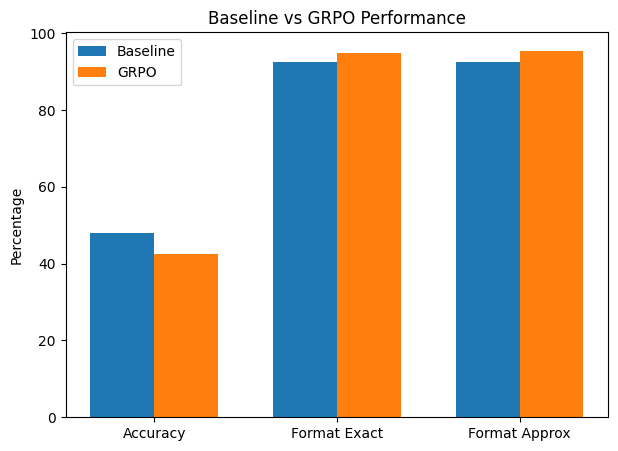


=== Sample Before vs After GRPO ===

--- Example 14 ---
Question: Reena and Shaloo are partners in a business, Reena invests Rs, 35,000 for 8 months and Shaloo invests Rs. 42,000 for 10 months, out of a profit of Rs. 31,570, Reena's share is ?
Options: (A) A)12628; (B) B)12228; (C) C)22812; (D) D)12727; (E) E)11922
Reference: A)12628
Baseline: <|system|>
You are a financial and math reasoning assistant. Use step-by-step reasoning.
<|user|>
Reena and Shaloo are partners in a business, Reena invests Rs, 35,000 for 8 months and Shaloo invests Rs. 42,000 for 10 months, out of a profit of Rs. 31,570, Reena's share is?
Options: (A) A)12628; (B) B)12228; (C) C)22812; (D) D)12727; (E) E)11922
<|assistant|>
<start_contemplating> Explanation:
Reena : Shaloo = 35000 * 8 : 42000 * 10 = 2 : 3
Reena's share = 31570 * 3/5 = Rs. 11922
Answer: Option E <end_contemplating><SOLUTION>E)11922</SOLUTION>
GRPO: <|system|>
You are a financial and math reasoning assistant. Use step-by-step reasoning.
<|user|>

In [8]:
# ===== Updated Point 7: Evaluation & Visualization =====

import matplotlib.pyplot as plt
import torch
import numpy as np
import random
from tqdm import tqdm

# -------------------
# Eval dataset prep
# -------------------
# If you have a validation set prepared, use that; else sample from train_filt
eval_ds = train_filt.shuffle(seed=SEED).select(range(min(200, len(train_filt))))
print(f"Evaluation set size: {len(eval_ds)}")

# Load GRPO model (LoRA applied)
from unsloth import FastLanguageModel
model_grpo, tokenizer_grpo = FastLanguageModel.from_pretrained(
    model_name="./grpo_out",
    max_seq_length=CUT_LEN,
    dtype=torch.bfloat16 if MIXED_PRECISION in ("bf16", torch.bfloat16) else torch.float16 if MIXED_PRECISION in ("fp16", torch.float16) else None,
    load_in_4bit=False,
)

# Ensure model is on GPU
model_grpo = model_grpo.to("cuda")

# -------------------
# Utility to run inference
# -------------------
def run_model_inference(model, tokenizer, prompts, max_new_tokens=256):
    model.eval()
    outputs = []
    for prompt in tqdm(prompts, desc="Generating"):
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        with torch.no_grad():
            gen = model.generate(**inputs, max_new_tokens=max_new_tokens, temperature=0.7, top_p=0.95)
        outputs.append(tokenizer.decode(gen[0], skip_special_tokens=True))
    return outputs

# -------------------
# Build chat-formatted prompts
# -------------------
eval_prompts = [
    to_chat_text([
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": ex['question']}
    ])
    for ex in eval_ds
]

# -------------------
# Evaluate baseline (before GRPO)
# -------------------
print("Evaluating baseline model...")
baseline_outputs = run_model_inference(model, tokenizer, eval_prompts)

# -------------------
# Evaluate GRPO model
# -------------------
print("Evaluating GRPO model...")
grpo_outputs = run_model_inference(model_grpo, tokenizer_grpo, eval_prompts)

# -------------------
# Metrics
# -------------------
def evaluate_outputs(outputs, refs):
    acc = 0
    fmt_exact = 0
    fmt_approx = 0
    for pred, ref in zip(outputs, refs):
        pred_text = _completion_to_text(pred)
        if reward_check_answer(completions=[pred_text], answer=[ref])[0] >= 5.0:
            acc += 1
        if reward_match_format_exactly(completions=[pred_text])[0] >= 3.0:
            fmt_exact += 1
        if reward_match_format_approx(completions=[pred_text])[0] >= 1.0:
            fmt_approx += 1
    total = len(outputs)
    return {
        "accuracy": acc / total * 100,
        "format_exact": fmt_exact / total * 100,
        "format_approx": fmt_approx / total * 100
    }

refs = [ex["final"] for ex in eval_ds]

baseline_metrics = evaluate_outputs(baseline_outputs, refs)
grpo_metrics = evaluate_outputs(grpo_outputs, refs)

print("\n=== Metrics ===")
print("Baseline:", baseline_metrics)
print("GRPO:", grpo_metrics)

# -------------------
# Visualization: Reward vs Steps
# -------------------
# If you have reward logs in `grpo_logs`, plot them
if 'grpo_logs' in locals() and hasattr(grpo_logs, 'log_history'):
    rewards = [log["reward"] for log in grpo_logs.log_history if "reward" in log]
    steps = list(range(len(rewards)))
    plt.figure(figsize=(6, 4))
    plt.plot(steps, rewards, label="Reward")
    plt.xlabel("Training Step")
    plt.ylabel("Reward")
    plt.title("Reward vs Steps")
    plt.legend()
    plt.show()

# -------------------
# Visualization: Accuracy comparison
# -------------------
labels = ["Accuracy", "Format Exact", "Format Approx"]
baseline_vals = [baseline_metrics["accuracy"], baseline_metrics["format_exact"], baseline_metrics["format_approx"]]
grpo_vals = [grpo_metrics["accuracy"], grpo_metrics["format_exact"], grpo_metrics["format_approx"]]

x = np.arange(len(labels))
width = 0.35
plt.figure(figsize=(7, 5))
plt.bar(x - width/2, baseline_vals, width, label='Baseline')
plt.bar(x + width/2, grpo_vals, width, label='GRPO')
plt.xticks(x, labels)
plt.ylabel("Percentage")
plt.title("Baseline vs GRPO Performance")
plt.legend()
plt.show()

# -------------------
# Qualitative examples
# -------------------
print("\n=== Sample Before vs After GRPO ===")
for i in random.sample(range(len(eval_prompts)), 5):
    print(f"\n--- Example {i} ---")
    print("Question:", eval_ds[i]['question'])
    print("Reference:", eval_ds[i]['final'])
    print("Baseline:", baseline_outputs[i])
    print("GRPO:", grpo_outputs[i])


In [9]:
# 🔮 Inference & Save LoRA Adapters

os.makedirs('./lora_adapter', exist_ok=True)
model.save_pretrained('./lora_adapter')
tokenizer.save_pretrained('./lora_adapter')
print('Saved LoRA adapter to ./lora_adapter')

def chat_infer(question: str):
    prompt = to_chat_text([
        {"role":"system","content":SYSTEM_PROMPT},
        {"role":"user","content":question},
    ])
    lst_prompt = [prompt]
    return run_model_inference(model_grpo, tokenizer_grpo, prompt)

q1 = "If a stock grows 12% annually, what is its value after 5 years starting from $500?"
q2 = "If 40% of revenue is cost and total revenue is $12,000, what is the net profit?"

print('Q1 →', chat_infer(q1))
print('\nQ2 →', chat_infer(q2))


Saved LoRA adapter to ./lora_adapter


Generating: 100%|██████████| 195/195 [35:02<00:00, 10.78s/it]


Q1 → ['<|system|>\nYou are a financial and math reasoning assistant. Use step-by-step reasoning.\n<|user|>\nIn a certain game, the probability that a player will make a basket is 0.55. If the player makes the basket, the probability that the player will make a free throw is 0.35. If the player does not make the basket, the probability that the player will make a free throw is 0.65. What is the probability that the player will make at least one free throw?\nOptions: (A) A)0.55; (B) B)0.55 + 0.35; (C) C)0.55 + 0.35 + 0.65; (D) D)0.55 + 0.35 + 0.65 + 0.25; (E) E)0.55 + 0.35 + 0.65 + 0.25 + 0.45\n<|assistant|>\n<start_contemplating> Probability of making a basket = 0.55\nProbability of making a free throw after making a basket = 0.35\nProbability of making a free throw after missing a basket = 0.', '| 2016 | 2015 | 2014 | 2013 | 2012 | 2011 | 2010 | 2009 | 2008 | 2007 | 2006 | 2005 | 2004 | 2003 | 2002 | 2001 | 2000 | 1999 | 1998 | 1997 | 1996 | 1995 | 1994 | 1993 | 1992 | 1991 | 1990 | 19

Generating: 100%|██████████| 192/192 [33:55<00:00, 10.60s/it]


Q2 → ['<|system|>\nYou are a financial and math reasoning assistant. Use step-by-step reasoning.\n<|user|>\nA train crosses a platform in 15 seconds while it is moving with a speed of 36 kmph. What is the length of the platform in meters?\nOptions: (A) A)150; (B) B)250; (C) C)100; (D) D)200; (E) E)300\n<|assistant|>\n<start_contemplating> Speed = (36 * 5/18) m/sec = 10 m/sec. Time = 15 sec. Let the length of the platform be x meters. Then, (x + 10)/15 = 10 => x + 150 = 150 => x = 0. Then, length of the platform\n= 0 + 10 = 10 m. Answer: Option C <end_contemplating><SOLUTION>C)100</SOLUTION> <start_contemplating> Solution (C) <end_contemplating> <start_contemplating> Let the length of the platform be x meters. Then, (x + 10)/15 = 10 => x + 150 = 150 => x =', '|« | »| |< | >| |<< | >>| |<< | >>| << | >>| « | »| |< | >| |<< | >>| |<< | >>|\nSedgwick, John\n(1804-1886) A British statesman and member of Parliament, Sedgwick was a member of the Reform League and an early supporter of the Re

In [10]:
from google.colab import drive
import shutil
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define save directory on Drive
SAVE_DIR = "/content/drive/MyDrive/qwen3_finance_math_project"
os.makedirs(SAVE_DIR, exist_ok=True)

# Paths to important folders
folders_to_save = {
    "lora_adapter": "/content/lora_adapter",
    "grpo_out": "/content/grpo_out"
}

# Zip and save each folder
for name, path in folders_to_save.items():
    if os.path.exists(path):
        zip_path = f"{SAVE_DIR}/{name}.zip"
        print(f"Zipping {name} to {zip_path}...")
        shutil.make_archive(zip_path.replace(".zip", ""), 'zip', path)

print(f"✅ All important folders have been zipped and saved to {SAVE_DIR}")


Mounted at /content/drive
Zipping lora_adapter to /content/drive/MyDrive/qwen3_finance_math_project/lora_adapter.zip...
Zipping grpo_out to /content/drive/MyDrive/qwen3_finance_math_project/grpo_out.zip...
✅ All important folders have been zipped and saved to /content/drive/MyDrive/qwen3_finance_math_project
